In [ ]:
%%capture
!pip install  transformers datasets peft evaluate

In [ ]:
# General
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
import datasets
from datasets import load_dataset

# DataLoader
from torch.utils.data import DataLoader

# Transformers
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    default_data_collator,
    T5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    T5Config
)

# PEFT
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    PromptEncoderConfig
)

# Adapter
# from adapters import AutoAdapterModel

# Evaluation
import evaluate

# Visualization
from sklearn.manifold import TSNE


In [ ]:
#Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
#load the pre-trained t5 model
model = AutoModelForSeq2SeqLM.from_pretrained(
    "google-t5/t5-small",
    torch_dtype=torch.float16,
    device_map="auto"
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# loading dataset
dataset = load_dataset("imdb", split=['train', 'test', 'unsupervised'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small") #load the pre-trained tokenizer
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id #if padding token is not set, use eos_token_id as padding token
classes = ["positive", "negative", "neutral"] #class labels for sentiment analysis
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(target_max_length) #number of tokens for any class label

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2


In [ ]:
def tokenize(examples):
    # add task prompt
    inputs = [f"review: {x} sentiment:" for x in examples["text"]]

    # natural language labels
    classes = ["negative", "positive"]
    targets = [classes[label] for label in examples["label"]]

    model_inputs = tokenizer(
        inputs,
        padding="max_length",
        truncation=True,
        max_length=512
    )

    labels = tokenizer(
        text_target=targets,
        truncation=True,
        max_length=2
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs




In [ ]:
tokenized_ds = dataset.map(
    tokenize,
    batched=True,
    num_proc=4,
    remove_columns=dataset["train"].column_names,
)

Map (num_proc=4):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
train_ds = tokenized_ds["train"] # train dataset
eval_ds = tokenized_ds["validation"] # test dataset
test_ds = tokenized_ds["test"]

In [ ]:
from evaluate import load

accuracy = load("accuracy")


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=-1)  # if classification
    return accuracy.compute(predictions=preds, references=labels)

In [ ]:

def train_and_get_metrics_LoRA(r, model):  #here, function in implemented to implement analysis in later part
  config = LoraConfig(
    r=r, #rank of low rank matrices
    lora_alpha=r, #et scaling factor ame as r
    target_modules=["q", "k", "v", "o"],   #apply LoRA only to query and key
    lora_dropout=0.1, #prevent overfitting on the low-rank adapter weights A and B
    bias="none",
    modules_to_save=["classifier"],
  )
  model = get_peft_model(model, config) #wrap the base model with PEFT and LoRA
  #model.print_trainable_parameters()
  batch_size = 8

  args = TrainingArguments(
      "./lora_outputs", #output directory name
      learning_rate=5e-3,
      per_device_train_batch_size=batch_size,
      gradient_accumulation_steps=4, #accumulate gradients over 4 steps, effective batch size = batch_size * 4
      per_device_eval_batch_size=batch_size,
      fp16=True, #half precision training
      num_train_epochs=5,
      logging_steps=100, #check training process
      label_names=["labels"],
      gradient_checkpointing=True, #new #saves memory by recomputing gradients during back prop
      save_strategy="steps", #checkpoints
      eval_strategy="steps",
      save_steps=100,
      eval_steps=100,
      load_best_model_at_end = True,
      metric_for_best_model="eval_loss",
      greater_is_better=False,
      )

# Create early stopping callback
  early_stopping_callback = EarlyStoppingCallback(
     early_stopping_patience=1  # Stop training if no improvement for 2 evaluations
      )

  trainer = Trainer( #initialize trainer
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
 )

  return trainer, model


# r = 16

In [ ]:
r = 16
trainer_16, lora_16 = train_and_get_metrics_LoRA(r, model)
lora_16.print_trainable_parameters()
result_16 = trainer_16.train()
print("Training Metrics: ",result_16.metrics)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-4258039578.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( #initialize trainer


trainable params: 1,179,648 || all params: 61,686,272 || trainable%: 1.9123


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.40 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.40 GiB is free. Process 2044 has 10.34 GiB memory in use. Of the allocated memory 6.75 GiB is allocated by PyTorch, and 3.46 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
metrics = trainer_16.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics)

Evaluation Metrics:  {'eval_loss': 0.15074031054973602, 'eval_runtime': 43.5035, 'eval_samples_per_second': 114.933, 'eval_steps_per_second': 14.367, 'epoch': 0.32}


In [ ]:
results = []
results.append({
        "r": r,
        "eval_loss": metrics["eval_loss"],
        "train_time_sec": result_16.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad)/ sum(p.numel() for p in model.parameters()) * 100,
        "train_loss" : result_16.metrics["train_loss"],
     })

# r = 8

In [ ]:
r=8
epoch=3
trainer_8, lora_8 = train_and_get_metrics_LoRA(r, model)
lora_8.print_trainable_parameters()
result_8 = trainer_8.train()
print("Training Metrics: ",result_8.metrics)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-1999127122.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( #initialize trainer


trainable params: 589,824 || all params: 61,096,448 || trainable%: 0.9654


Step,Training Loss,Validation Loss
100,0.984300,0.162606
200,0.157900,0.145698
300,0.160000,0.134669
400,0.150200,0.140722


Training Metrics:  {'train_runtime': 564.9978, 'train_samples_per_second': 176.992, 'train_steps_per_second': 5.531, 'total_flos': 1755567882240000.0, 'train_loss': 0.36309209823608396, 'epoch': 0.64}


In [ ]:
metrics_8 = trainer_8.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics_8)

Evaluation Metrics:  {'eval_loss': 0.1346692144870758, 'eval_runtime': 37.8988, 'eval_samples_per_second': 131.93, 'eval_steps_per_second': 16.491, 'epoch': 0.64}


In [ ]:

results.append({
        "r": r,
        "eval_loss": metrics_8["eval_loss"],
        "train_time_sec": result_8.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad)/ sum(p.numel() for p in model.parameters()) * 100,
        "train_loss" : result_8.metrics["train_loss"],
     })

In [ ]:
results

[{'r': 16,
  'eval_loss': 0.15074031054973602,
  'train_time_sec': 278.9107,
  'trainable_params': 1.912334724977382,
  'train_loss': 0.5503782558441163},
 {'r': 8,
  'eval_loss': 0.1346692144870758,
  'train_time_sec': 564.9978,
  'trainable_params': 0.9653981848502878,
  'train_loss': 0.36309209823608396}]

# r = 4

In [ ]:

def train_and_get_metrics_LoRA(r, model):  #here, function in implemented to implement analysis in later part
  config = LoraConfig(
    r=r, #rank of low rank matrices
    lora_alpha=r, #et scaling factor ame as r
    target_modules=["q", "k", "v", "o"],   #apply LoRA only to query and key
    lora_dropout=0.1, #prevent overfitting on the low-rank adapter weights A and B
    bias="none",
    modules_to_save=["classifier"],
  )
  model = get_peft_model(model, config) #wrap the base model with PEFT and LoRA
  #model.print_trainable_parameters()
  batch_size = 4

  args = TrainingArguments(
      "./lora_outputs", #output directory name
      learning_rate=5e-3,
      per_device_train_batch_size=batch_size,
      gradient_accumulation_steps=4, #accumulate gradients over 4 steps, effective batch size = batch_size * 4
      per_device_eval_batch_size=batch_size,
      fp16=True, #half precision training
      num_train_epochs=5,
      logging_steps=100, #check training process
      label_names=["labels"],
      gradient_checkpointing=True, #new #saves memory by recomputing gradients during back prop
      save_strategy="steps", #checkpoints
      eval_strategy="steps",
      save_steps=500,
      load_best_model_at_end = True,
      )

# Create early stopping callback
  early_stopping_callback = EarlyStoppingCallback(
     early_stopping_patience=2  # Stop training if no improvement for 2 evaluations
      )

  trainer = Trainer( #initialize trainer
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=default_data_collator,

    callbacks=[early_stopping_callback]
 )

  return trainer, model



In [ ]:
r=4
epoch=3
trainer_4, lora_4 = train_and_get_metrics_LoRA(r, model)
lora_4.print_trainable_parameters()
result_4 = trainer_4.train()
print("Training Metrics: ",result_4.metrics)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-4146146651.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( #initialize trainer


trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850


Step,Training Loss,Validation Loss
100,1.191800,0.140307
200,0.160100,0.132070
300,0.157100,0.132943
400,0.163400,0.128643
500,0.157200,0.136522
600,0.169900,0.137186


Training Metrics:  {'train_runtime': 2190.0735, 'train_samples_per_second': 45.661, 'train_steps_per_second': 2.854, 'total_flos': 1307978602905600.0, 'train_loss': 0.33325113932291667, 'epoch': 0.48}


In [ ]:
metrics_4 = trainer_4.evaluate(eval_dataset=eval_ds)
print("Evaluation Metrics: ", metrics_4)

Evaluation Metrics:  {'eval_loss': 0.13718600571155548, 'eval_runtime': 309.8419, 'eval_samples_per_second': 80.686, 'eval_steps_per_second': 20.172, 'epoch': 0.48}


In [ ]:
results.append({
        "r": r,
        "eval_loss": metrics_4["eval_loss"],
        "train_time_sec": result_4.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad)/ sum(p.numel() for p in model.parameters()) * 100,
        "train_loss" : result_4.metrics["train_loss"],
     })

In [ ]:
results

[{'r': 16,
  'eval_loss': 0.10963243246078491,
  'train_time_sec': 3319.2183,
  'trainable_params': 1.912334724977382,
  'train_loss': 0.387672088543574},
 {'r': 8,
  'eval_loss': 0.16325673460960388,
  'train_time_sec': 3009.1273,
  'trainable_params': 0.9653981848502878,
  'train_loss': 1.0826624953746795},
 {'r': 4,
  'eval_loss': 0.13718600571155548,
  'train_time_sec': 2190.0735,
  'trainable_params': 0.48504037792729443,
  'train_loss': 0.33325113932291667}]

# r = 2

In [ ]:
r = 2
trainer_2, lora_2 = train_and_get_metrics_LoRA(r, model)
lora_2.print_trainable_parameters()
result_2 = trainer_2.train()
print("Training Metrics: ",result_2.metrics)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-1999127122.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( #initialize trainer


trainable params: 147,456 || all params: 60,654,080 || trainable%: 0.2431


Step,Training Loss,Validation Loss
100,1.262100,0.140067
200,0.153900,0.124510
300,0.157700,0.117157
400,0.143200,0.122199


Training Metrics:  {'train_runtime': 1150.978, 'train_samples_per_second': 86.883, 'train_steps_per_second': 2.715, 'total_flos': 1738173264691200.0, 'train_loss': 0.429229691028595, 'epoch': 0.64}


In [ ]:
metrics_2 = trainer_2.evaluate()

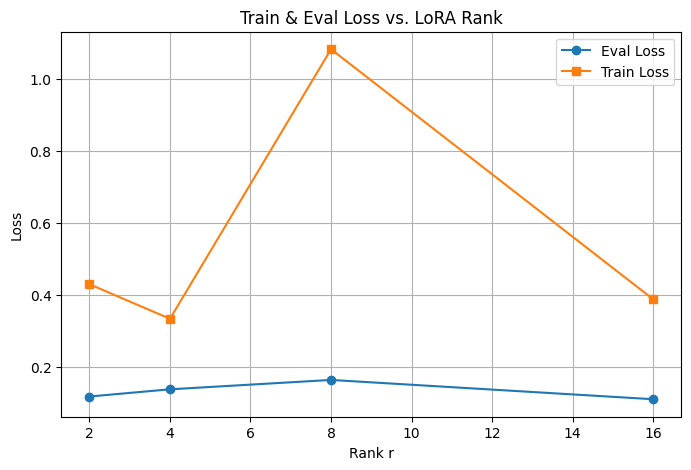

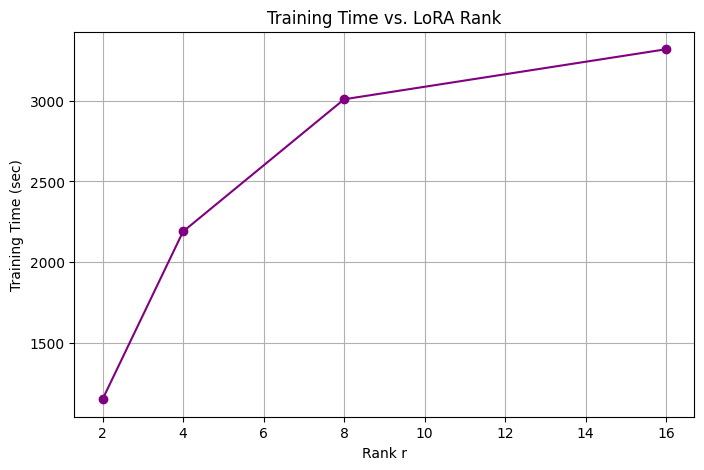

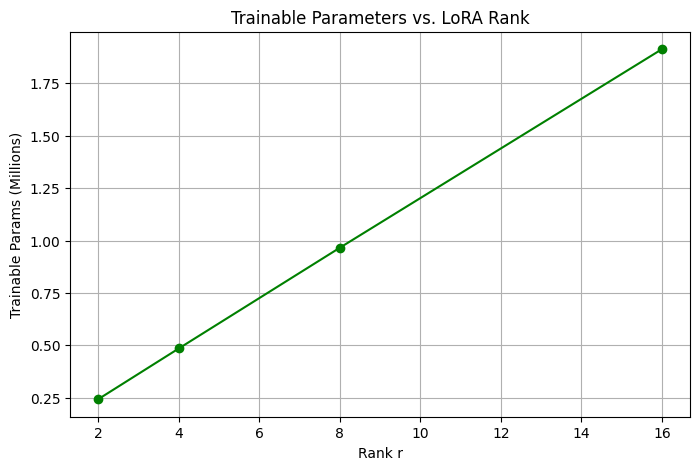

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Plot losses vs r
plt.figure(figsize=(8,5))
plt.plot(df["r"], df["eval_loss"], marker="o", label="Eval Loss")
plt.plot(df["r"], df["train_loss"], marker="s", label="Train Loss")
plt.xlabel("Rank r")
plt.ylabel("Loss")
plt.title("Train & Eval Loss vs. LoRA Rank")
plt.legend()
plt.grid(True)
plt.show()

# Plot training time vs r
plt.figure(figsize=(8,5))
plt.plot(df["r"], df["train_time_sec"], marker="o", color="purple")
plt.xlabel("Rank r")
plt.ylabel("Training Time (sec)")
plt.title("Training Time vs. LoRA Rank")
plt.grid(True)
plt.show()

# Plot trainable params vs r
plt.figure(figsize=(8,5))
plt.plot(df["r"], df["trainable_params"], marker="o", color="green")
plt.xlabel("Rank r")
plt.ylabel("Trainable Params (Millions)")
plt.title("Trainable Parameters vs. LoRA Rank")
plt.grid(True)
plt.show()

In [ ]:
metrics_2

{'eval_loss': 0.11715738475322723,
 'eval_runtime': 189.3733,
 'eval_samples_per_second': 132.014,
 'eval_steps_per_second': 16.502,
 'epoch': 0.64}

In [ ]:
results=[{'r': 16,
  'eval_loss': 0.10963243246078491,
  'train_time_sec': 3319.2183,
  'trainable_params': 1.912334724977382,
  'train_loss': 0.387672088543574},
 {'r': 8,
  'eval_loss': 0.16325673460960388,
  'train_time_sec': 3009.1273,
  'trainable_params': 0.9653981848502878,
  'train_loss': 1.0826624953746795},
 {'r': 4,
  'eval_loss': 0.13718600571155548,
  'train_time_sec': 2190.0735,
  'trainable_params': 0.48504037792729443,
  'train_loss': 0.33325113932291667}]

In [ ]:
results.append({
        "r": r,
        "eval_loss": metrics_2["eval_loss"],
        "train_time_sec": result_2.metrics["train_runtime"],
        "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad)/ sum(p.numel() for p in model.parameters()) * 100,
        "train_loss" : result_2.metrics["train_loss"],
     })

In [ ]:
results

[{'r': 16,
  'eval_loss': 0.10963243246078491,
  'train_time_sec': 3319.2183,
  'trainable_params': 1.912334724977382,
  'train_loss': 0.387672088543574},
 {'r': 8,
  'eval_loss': 0.16325673460960388,
  'train_time_sec': 3009.1273,
  'trainable_params': 0.9653981848502878,
  'train_loss': 1.0826624953746795},
 {'r': 4,
  'eval_loss': 0.13718600571155548,
  'train_time_sec': 2190.0735,
  'trainable_params': 0.48504037792729443,
  'train_loss': 0.33325113932291667},
 {'r': 2,
  'eval_loss': 0.11715738475322723,
  'train_time_sec': 1150.978,
  'trainable_params': 0.24310977925969696,
  'train_loss': 0.429229691028595}]

In [ ]:
trainer_2.evaluate()

KeyboardInterrupt: 